In [1]:
import torch
import torch.optim as optim
import torch.utils.data
import torch.backends.cudnn as cudnn
from torch.utils.data import random_split
from torch.utils.data.dataset import Dataset
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os

import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
import torchvision
from torchvision import transforms, datasets

In [3]:
# Parse file nums to dicts
images_file_path = os.getcwd() + '/../data/images'
image_ids = []
for file in os.listdir(images_file_path):
    filename = os.fsdecode(file)
    image_ids.append(filename[2:-4])

train_ids, dev_ids = train_test_split(image_ids, test_size=0.2)

In [4]:
#--- hyperparameters ---
N_EPOCHS = 20
BATCH_SIZE_TRAIN = 128
BATCH_SIZE_DEV = 16
LR = 0.001

In [5]:
NUM_CLASSES = 14
DATA_DIR = os.getcwd() + '/../data/'

In [7]:
from collections import defaultdict

class ProjectDataset(Dataset):
    img_classes = [
        'baby', 'bird', 'car', 'clouds', 'dog', 
        'female', 'flower', 'male', 'night', 
        'people', 'portrait', 'river', 'sea', 'tree'
    ]
    
    def __init__(self, image_folder, annotation_folder, selected_keys, is_test=False, transform=None, target_transform=None):
        data = {key: {'file': f'im{key}.jpg', 'labels': []} for key in selected_keys}
        self.data = []
        self.classes = ProjectDataset.img_classes

        self.classes_data = {}
        
        if not is_test:
            for file in os.listdir(annotation_folder):
                filename = os.fsdecode(file)
                cls = filename.split('.')[0]
                file_path = os.path.join(annotation_folder, filename)

                self.classes_data[cls] = 0

                with open(file_path, 'r') as f:
                    for line in f.readlines():
                        idx = line.replace('\n', '')
                        if idx in selected_keys:
                            self.classes_data[cls] += 1
                            data[idx]['labels'].append(cls)
        
        self.diagnostic = defaultdict(lambda: 0)
        
        for key, val in data.items():
            filename = val['file']
            self.diagnostic[len(val['labels'])] += 1
            labels = torch.Tensor([x in val['labels'] for x in self.classes])
            self.data.append({'file': filename, 'labels': labels})
        
        self.image_folder = image_folder
        self.transform = transform
        self.target_transform = target_transform
    
    def __getitem__(self, item):
        data = self.data[item]
        labels = data['labels']
        image_path = os.path.join(self.image_folder, data['file'])
        image = torchvision.io.read_image(image_path, torchvision.io.ImageReadMode.RGB)
        image = image.type(torch.FloatTensor)
        image = torch.div(image, 255)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            labels = self.target_transform(labels)
            
        return image, labels
    
    def __len__(self):
        return len(self.data)
    
    def draw_diagrams(self):
        plt.figure(1)
        print(self.classes_data)
        plt.bar(self.classes_data.keys(), self.classes_data.values())
        plt.xticks(rotation=70)
        plt.figure(2)
        print(dict(self.diagnostic))
        plt.bar(self.diagnostic.keys(), self.diagnostic.values())

{'baby': 95, 'bird': 360, 'car': 319, 'clouds': 1095, 'dog': 448, 'female': 3227, 'flower': 761, 'male': 2979, 'night': 598, 'people': 6403, 'portrait': 3121, 'river': 120, 'sea': 173, 'tree': 525}
{3: 3230, 0: 9824, 2: 2388, 1: 4161, 4: 388, 5: 9}


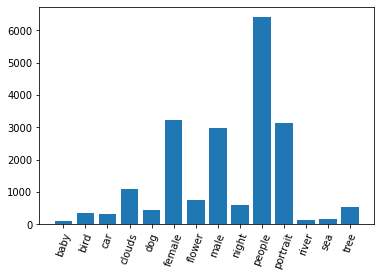

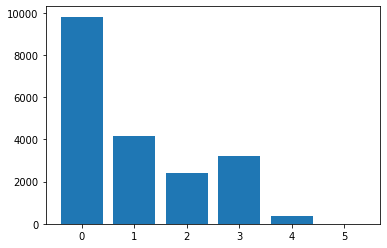

In [96]:
# For making plots about the data
ProjectDataset(DATA_DIR + 'images', DATA_DIR + 'annotations', [str(i) for i in range(1, 20001)]).draw_diagrams()

In [9]:
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      #transforms.RandomPerspective(distortion_scale=0.2),
                                      #transforms.ColorJitter(),
                                      #transforms.ToTensor()
                                     ])
dev_transform = transforms.Compose([])

annotation_path = DATA_DIR + 'annotations'
image_path = DATA_DIR + 'images'
test_path = DATA_DIR + 'test'
train_set = ProjectDataset(image_path, annotation_path, selected_keys=train_ids, transform=train_transform)
dev_set = ProjectDataset(image_path, annotation_path, selected_keys=dev_ids, transform=dev_transform)
test_set = ProjectDataset(test_path, None, is_test=True, selected_keys=list(range(20001, 25001)))


# Create Pytorch data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
dev_loader = torch.utils.data.DataLoader(dataset=dev_set, batch_size=BATCH_SIZE_DEV, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=BATCH_SIZE_DEV, shuffle=False)

In [10]:
#--- model ---
class CNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Linear(32768, NUM_CLASSES)
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        out = self.sigm(out)
        return out

In [11]:
labels_in_order = ProjectDataset.img_classes

def calc_batch_metrics(targets, preds):
    t = np.asarray(targets)
    p = np.asarray(preds)
    false_neg = np.sum(np.logical_and(p == 0, t == 1))
    false_pos = np.sum(np.logical_and(p == 1, t == 0))
    true_neg = np.sum(np.logical_and(p == 0, t == 0))
    true_pos = np.sum(np.logical_and(p == 1, t == 1))
    
    recall = true_pos / (true_pos + false_pos)
    precision = true_pos / (true_pos + false_neg)
    f1_score = 2 * (precision*recall / (precision+recall))
    return precision, recall, f1_score

def labels_by_metric(targets, preds):
        false_neg_labels = { x:0 for x in labels_in_order}
        false_pos_labels = { x:0 for x in labels_in_order}
        true_neg_labels = { x:0 for x in labels_in_order}
        true_pos_labels = { x:0 for x in labels_in_order}
        for tar, pred in zip(np.asarray(targets), np.asarray(preds)):
            for t, p, label in zip(tar,pred,labels_in_order):
                if(t == 0 and p == 0):
                    true_neg_labels[label] += 1
                if(t == 1 and p == 1):
                    true_pos_labels[label] += 1
                if(t == 0 and p == 1):
                    false_pos_labels[label] += 1
                if(t == 1 and p == 0):
                    false_neg_labels[label] += 1
        return false_neg_labels, false_pos_labels, true_neg_labels, true_pos_labe

using gpu
 Training: Epoch 0 - Batch 124/125: Loss: 0.2270 ---
Precision:  0.33238881360108413
Recall:  0.2406887015477943
F1 Score:  0.27920213178795955
---

 Dev: Epoch 0 - Batch 249/250: Loss: 0.2095ev: Epoch 0 - Batch 52/250: Loss: 0.2091
Epoch dev loss: 52.37543573975563
Previous epoch dev loss: 1000000

---
Precision:  0.3300751879699248
Recall:  0.30450867052023123
F1 Score:  0.3167769092002406
---

 Training: Epoch 1 - Batch 124/125: Loss: 0.2060 ---
Precision:  0.3272144881113712
Recall:  0.3272749676544883
F1 Score:  0.3272447250885569
---

 Dev: Epoch 1 - Batch 249/250: Loss: 0.2046
Epoch dev loss: 51.14974234253168
Previous epoch dev loss: 52.37543573975563

---
Precision:  0.28972431077694233
Recall:  0.33497536945812806
F1 Score:  0.31071092595081307
---

 Training: Epoch 2 - Batch 124/125: Loss: 0.2020 ---
Precision:  0.3462486140199581
Recall:  0.3408939292861908
F1 Score:  0.34355040796992936
---

 Dev: Epoch 2 - Batch 249/250: Loss: 0.2021
Epoch dev loss: 50.514721833

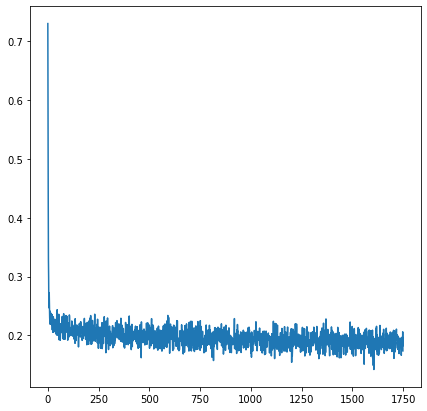

In [12]:
#--- set up ---
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('using gpu')
else:
    print('using cpu')
    device = torch.device('cpu')

model = CNN().to(device)

# OPTIMIZERS & REGURALIZATION
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.5)
loss_function = nn.BCELoss()

#--- TRAINING ---

previous_train_loss = 1000000
previous_dev_loss = 1000000

batch_losses = []

for epoch in range(N_EPOCHS):
    train_loss = 0
    preds = []
    targets = []
    
    for batch_num, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        # Compute prediction error
        optimizer.zero_grad()
        pred = model(data)
        loss = loss_function(pred, target)

        train_loss += loss.item()
                
        batch_losses.append(loss.item())
        
        preds.extend((pred > 0.25).float().cpu().numpy())
        targets.extend(target.cpu().numpy())
        
        # Backpropagation
        loss.backward()
        optimizer.step()

        print('\r', 'Training: Epoch %d - Batch %d/%d: Loss: %.4f ' % 
              (epoch, batch_num, len(train_loader), train_loss / (batch_num + 1)), end='')
        
    
    precision, recall, f1_score = calc_batch_metrics(targets, preds)
    print('---')
    print('Precision: ' , precision)
    print('Recall: ' , recall) 
    print('F1 Score: ' , f1_score)
    print('---')
    
    print()
    dev_loss = 0
    
    dev_preds = []
    dev_targets = []
    
    for batch_num, (data, target) in enumerate(dev_loader):
        data, target = data.to(device), target.to(device)
               
        # Compute prediction error
        pred = model(data)
        loss = loss_function(pred, target)
        dev_loss += loss.item()
    
        dev_preds.extend((pred > 0.25).float().cpu().numpy())
        dev_targets.extend(target.cpu().numpy())
       
        print('\r', 'Dev: Epoch %d - Batch %d/%d: Loss: %.4f' % 
             (epoch, batch_num, len(dev_loader), dev_loss / (batch_num + 1)), end='')
    
    print()
    print("Epoch dev loss: " + str(dev_loss))
    print("Previous epoch dev loss: " + str(previous_dev_loss))
    print()
    
    dprecision, drecall, df1_score = calc_batch_metrics(dev_targets, dev_preds)
    print('---')
    print('Precision: ' , dprecision)
    print('Recall: ' , drecall) 
    print('F1 Score: ' , df1_score)
    print('---')
    print()
    
    # EARLY STOPPING
    if dev_loss > previous_dev_loss:
        print('early stopping')
        break
        
    previous_dev_loss = dev_loss

plt.figure(figsize=(7, 7))
plt.plot(batch_losses)
plt.show()

torch.save(model, 'model.mdl')

In [17]:
#--- test ---

test_preds = []

with torch.no_grad():
    for batch_num, (data, target) in enumerate(test_loader):
        data = data.to(device)
        pred = model(data)
        test_preds.extend((pred > 0.25).float().cpu().numpy())
        print('\r', 'Evaluating: Batch %d/%d' % (batch_num, len(test_loader)), end='')

with open('test_result.txt', 'w') as f:
    for result in test_preds:
        f.write(' '.join([str(int(i)) for i in result]))
        f.write('\n')

 Evaluating: Batch 312/313valuating: Batch 22/313

In [ ]:
### PLOTS FOR DOCUMENTATION ###

false_neg_labels, false_pos_labels, true_neg_labels, true_pos_labels = labels_by_metric(targets, preds)

labels = labels_in_order

# NEGATIVES

fn = list(false_neg_labels.values())
tn = list(true_neg_labels.values())

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, fn, width, label='FN')
rects2 = ax.bar(x + width/2, tn, width, label='TN')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('TN vs. FN')
ax.set_title('Number of preds')
ax.set_xticks(x, labels, rotation='vertical')
ax.legend()

ax.bar_label(rects1, padding=10)
ax.bar_label(rects2, padding=10)

fig.tight_layout()
plt.show()

## POSITIVES

labels = labels_in_order
fp = list(false_pos_labels.values())
tp = list(true_pos_labels.values())

x = np.arange(len(labels))  
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, fp, width, label='FP')
rects2 = ax.bar(x + width/2, tp, width, label='TP')

ax.set_ylabel('Number of preds')
ax.set_title('TP vs. FP')
ax.set_xticks(x, labels, rotation='vertical')
ax.legend()

ax.bar_label(rects1, padding=10)
ax.bar_label(rects2, padding=10)

fig.tight_layout()
plt.show()